In [ ]:
#sempre lembrar de limpar a pasta tmp ao final do exercício

# import shutil
# shutil.rmtree('/tmp_img')
# shutil.rmtree('/tmp_csv')
# shutil.rmtree('/tmp_img_resized')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import cv2
import glob
import os
import re
from google.colab import drive
from functools import lru_cache
import requests
import seaborn as sns

In [2]:
RESCALE_RATIO = 35
states = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO', 'DF']

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def open_image_internet(url):
  return cv2.imdecode(np.asarray(bytearray(requests.get(url).content)), -1)

def open_image_local(path):
  img = cv2.imread(path, cv2.COLOR_BGR2RGB)
  return img

def BGR2RGB(img):
  return img[:,:,::-1]
  
def crop_image(img_orig):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
  gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces):
    (x,y,w,h) = faces[0]
    img_cropped = img_orig[
        max(0,y-30):
        min(img_orig.shape[0]-1,y+h+30), 
        max(0, x-30):
        min(img_orig.shape[1]-1,x+w+30),
        :]
    return img_cropped
  else:
    square = min(img_orig.shape[0], img_orig.shape[1])//2
    mid_height = img_orig.shape[0]//2
    mid_width = img_orig.shape[1]//2
    return img_orig[mid_height-square:mid_height+square,mid_width-square:mid_width+square]

def unzip_files(input_folder, file, output_folder):
  from_path = f'{input_folder}/{file}'
  zip_ref = zipfile.ZipFile(from_path, 'r')
  zip_ref.extractall(output_folder)
  zip_ref.close()

@lru_cache(maxsize=None)
def get_img_filenames(state):
  os.chdir('/tmp_img')
  img_lists = [glob.glob(e) for e in ('*'+state+'*.jpg', '*'+state+'*.png', '*'+state+'*.jpeg')]
  img_list = [item for sublist in img_lists for item in sublist]
  return set(img_list)

def get_img_filename_from_sq_candidato(state, sq_candidato):
  filenames = get_img_filenames(state)
  option1, option2 = 'F'+state+str(sq_candidato)+'_div.jpg', 'F'+state+str(sq_candidato)+'_div.jpeg'
  if option1 in filenames:
    return option1
  elif option2 in filenames:
    return option2
  else:
    return ''

def get_candidates_from_state(state):
  os.chdir('/tmp_csv')
  data_filename = glob.glob('*'+state+'.csv')
  data_df = pd.read_csv(r'/tmp_csv/'+data_filename[0], encoding='iso-8859-1', on_bad_lines='warn', sep=';')
  data_df['filename'] = data_df['SQ_CANDIDATO'].map(lambda sq_candidato: get_img_filename_from_sq_candidato(state, sq_candidato))
  return data_df[['NM_CANDIDATO', 'DS_CARGO', 'SQ_CANDIDATO', 'DS_SIT_TOT_TURNO', 'CD_SIT_TOT_TURNO', 'filename']].query('filename != ""') 

def get_candidates():
  return pd.concat([get_candidates_from_state(state) for state in states])

def get_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "ELEITO" or DS_SIT_TOT_TURNO == "ELEITO POR MÉDIA"') 

def get_not_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "NÃO ELEITO"')

def get_faces(elected_df):
  return np.array([open_image_local('/tmp_img/'+filename) for filename in elected_df['filename'].values])

def get_cropped_faces(faces):
  return np.array([crop_image(face) for face in faces])

def get_resized_faces_aux(cropped_faces, x_max, y_max):
  return np.array([cv2.resize(cropped_face, (x_max, y_max), interpolation = cv2.INTER_AREA) for cropped_face in cropped_faces])

def get_resized_faces(cropped_faces):
  y_max = np.max([cropped_face.shape[0] for cropped_face in cropped_faces])
  x_max = np.max([cropped_face.shape[1] for cropped_face in cropped_faces])
  return get_resized_faces_aux(cropped_faces, x_max, y_max)
  
def get_flatten_faces(faces):
  return faces.reshape((faces.shape[0], np.prod(faces.shape[1:])))

def output_imgs(folder, candidates_df, resized_imgs):
  if not os.path.exists(folder):
    os.makedirs(folder)
  os.chdir(folder)

  for idx_row in range(candidates_df.shape[0]):
    filename = candidates_df.iloc[idx_row]['filename']
    if filename != '':
      cv2.imwrite(filename, resized_imgs[idx_row])
    else:
      continue

Unzip Files

In [5]:
unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'consulta_cand_2022.zip', '/tmp_csv')
for state in states:
  unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'foto_cand2022_'+state+'_div.zip', '/tmp_img')

Save Resized Images (Only Play Me Once)

In [ ]:
candidates_df = get_candidates()
candidates_faces = get_faces(candidates_df)
candidates_faces = get_cropped_faces(candidates_faces)
candidates_faces = get_resized_faces(candidates_faces)
output_imgs('/tmp_img_resized',  candidates_df, candidates_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
from google.colab import files
!zip -r /content/img_resized.zip /tmp_img_resized
files.download("/content/img_resized.zip")


Play for Real

In [6]:
def see_cropped_faces(photos, cropped_photos, resized_cropped_photos, n_photos):
  n_cols = 3
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)
  fig, axs = plt.subplots(n_photos, n_cols, figsize=(15,30))
  for idx, (img_orig, img_cropp, img_resized) in enumerate(zip(photos[lines], cropped_photos[lines], resized_cropped_photos[lines])):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_cropp));
    axs[idx][2].imshow(BGR2RGB(img_resized));

In [ ]:
def pca_plot_faces_and_their_reconstructions(pca, photos, n_photos):
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)

  elected_person_images = photos[lines]

  flattened_faces = get_flatten_faces(elected_person_images)
  data_projected = pca.transform(flattened_faces)
  reconstructed_photos = pca.inverse_transform(data_projected).reshape((n_photos, photos.shape[1], photos.shape[2], photos.shape[3]))

  fig, axs = plt.subplots(n_photos, 2, figsize=(15,30))
  for idx, (img_orig, img_reconstructed) in enumerate(zip(elected_person_images, reconstructed_photos)):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_reconstructed));

Carregar Imagens

In [7]:
elected_df = get_elected(get_candidates())
elected_faces = get_faces(elected_df)
cropped_elected_faces = get_cropped_faces(elected_faces)
resized_cropped_ellected_faces = get_resized_faces(cropped_elected_faces)
elected_flattened_faces = get_flatten_faces(resized_cropped_ellected_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Faces: variável com os rostos dos candidatos eleitos

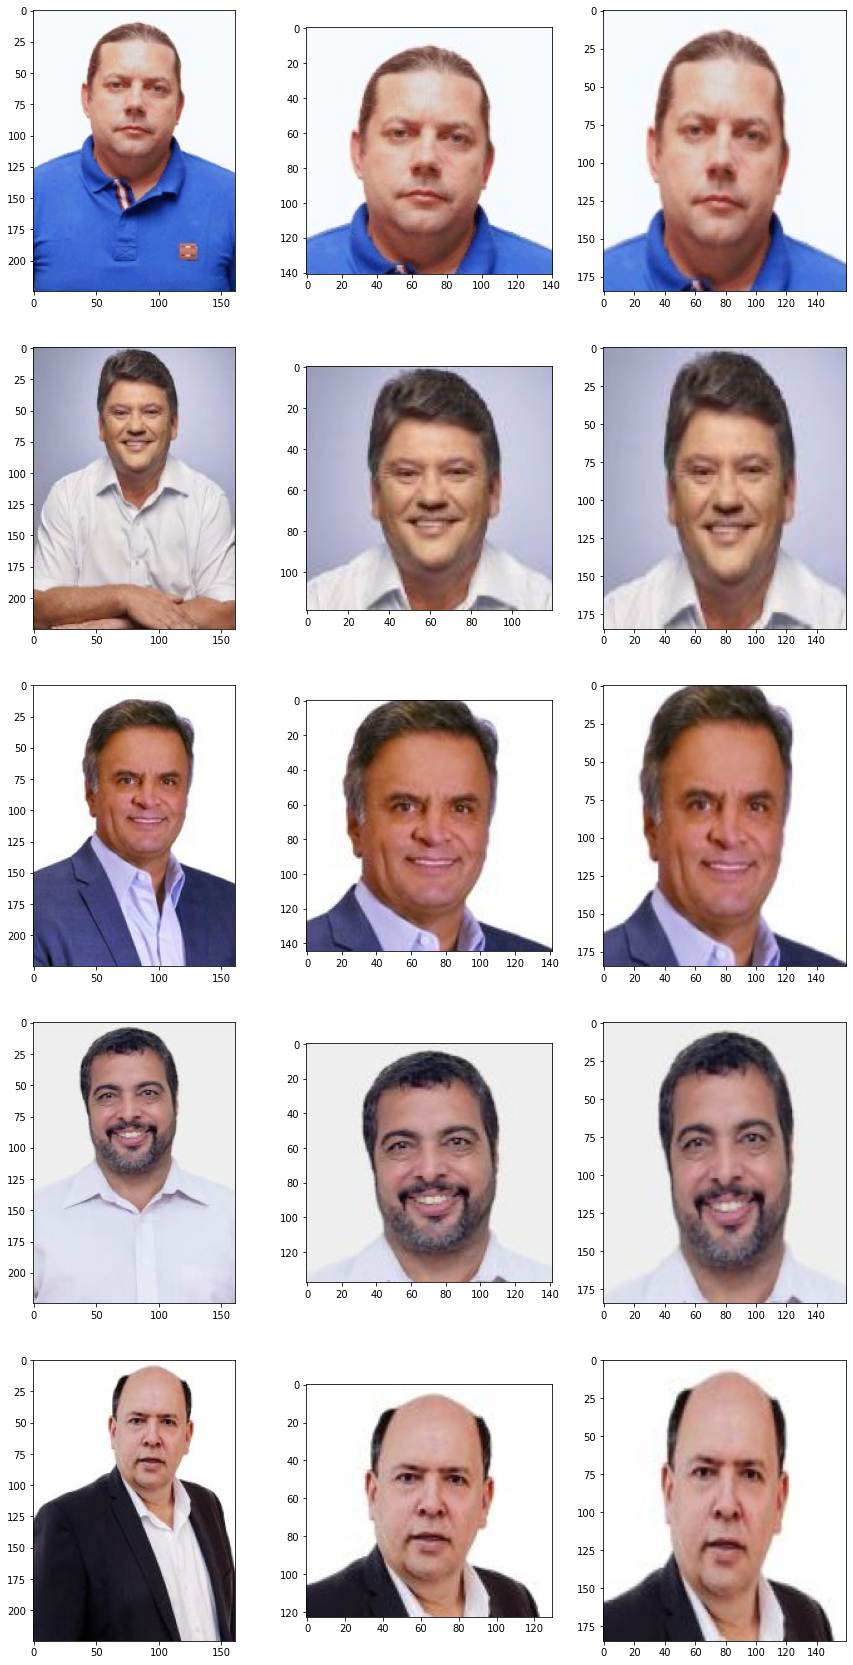

In [10]:
see_cropped_faces(elected_faces, cropped_elected_faces, resized_cropped_ellected_faces, 5)

PCA

Fonte: https://github.com/lewagon/data-challenges/blob/master/05-ML/06-Unsupervised-Learning/02-Face-Recognition/face_recognition.ipynb

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Construir o PCA dos candidatos eleitos com 10 componentes

In [12]:
pca = PCA(n_components=50, svd_solver='full').fit(elected_flattened_faces/255)

Play

Imagem Original vs. Reconstrução de uma Imagem 

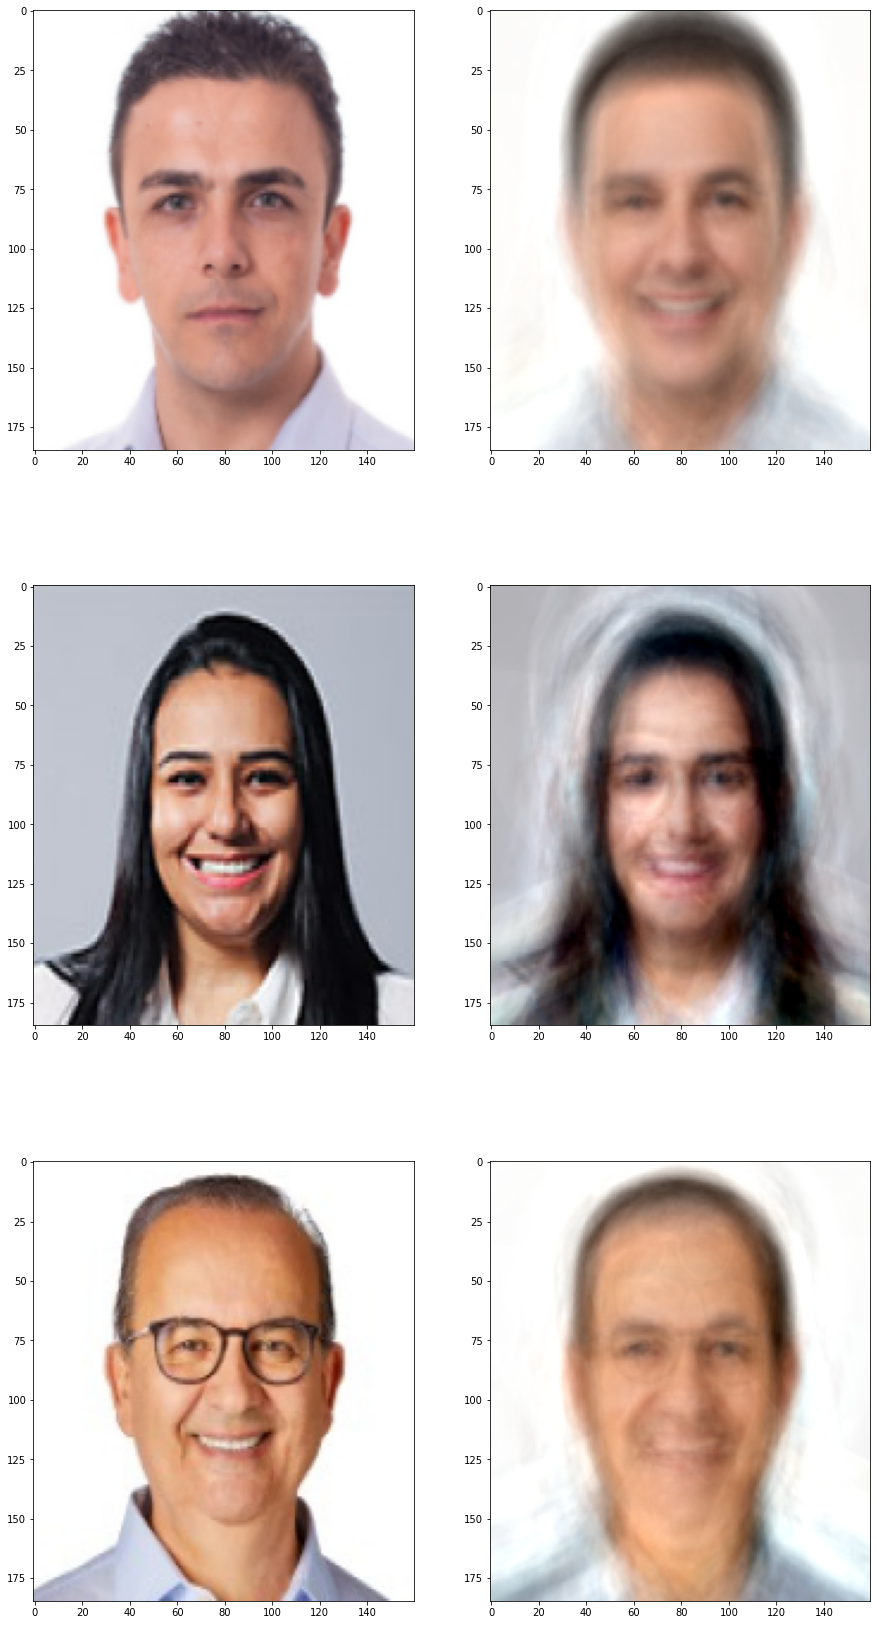

In [14]:
pca_plot_faces_and_their_reconstructions(pca, resized_cropped_ellected_faces/255, 3)

Imagens Reconstruídas

Reconstrução da imagem padrão de candidatos eleitos a partir do componente principal

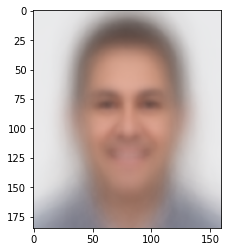

In [15]:
elected_mean_person_pca = pca.mean_.reshape(resized_cropped_ellected_faces.shape[1:])
plt.imshow(BGR2RGB(elected_mean_person_pca));

Busca pelo número ideal de componentes principais

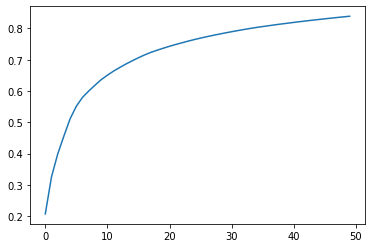

In [17]:
sns.lineplot(x=np.arange(pca.explained_variance_ratio_.shape[0]), y=pca.explained_variance_ratio_.cumsum())

Reconstrução da imagem padrão de candidatos eleitos a partir das componentes principais

In [18]:
def plot_main_components(pca, shape, n_components=1):
  sc = MinMaxScaler()
  sc = sc.fit(pca.components_)
  input_transformado = sc.transform(pca.components_[0:n_components])
  input_transformado = np.expand_dims(input_transformado.mean(axis=0), axis=1)
  input_transformado = input_transformado.reshape(shape)
  plt.imshow(BGR2RGB(input_transformado));

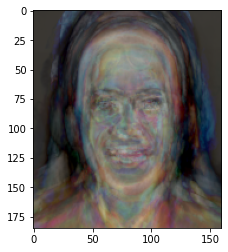

In [21]:
plot_main_components(pca, resized_cropped_ellected_faces.shape[1:], 1)

Autoencoder

Fonte: https://github.com/heliomacedofilho/data-challenges/blob/master/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder/autoencoders.ipynb

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Input, BatchNormalization, Dropout, Lambda, LeakyReLU
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [7]:
latent_dimension = 400

In [8]:
def autoencoder_plot_faces_and_their_reconstructions(autoencoder, photos, n_photos):
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)
  reconstructed_photos = autoencoder.predict(photos[lines])

  fig, axs = plt.subplots(n_photos, 2, figsize=(15,30))
  for idx, (img_orig, img_reconstructed) in enumerate(zip(photos[lines], reconstructed_photos)):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_reconstructed));

def plot_randomly_created_faces(decoder, n_photos):
  randomly_created_faces = decoder.predict(np.random.normal(0,1,size=(n_photos,latent_dimension)))

  fig, axs = plt.subplots(1, n_photos, figsize=(15,30))
  for idx, randomly_created_face in enumerate(randomly_created_faces):
    axs[idx].imshow(BGR2RGB(randomly_created_face));

In [9]:
candidates_df = get_candidates()

elected_df = get_elected(candidates_df)[['filename']].copy()
elected_df['y'] = 1

not_elected_df = get_not_elected(candidates_df)[['filename']]
not_elected_indices = np.random.choice(not_elected_df.shape[0], elected_df.shape[0], replace=False)
not_elected_df = not_elected_df.iloc[not_elected_indices].copy()
not_elected_df['y'] = 0

#candidates_df = pd.concat([elected_df, not_elected_df], axis=0).sample(frac=1)
candidates_df = elected_df

In [10]:
X = get_resized_faces(get_cropped_faces(get_faces(candidates_df.drop(columns='y'))))/255
y = candidates_df['y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
#Gambiarra para o autoencoder funcionar (input e ouput têm que ter as mesmas dimensões. Voltar aqui para consertar!)
X = get_resized_faces_aux(X, 160, 192)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, y_train = X, y

Encoder

In [12]:
def build_prefix_encoder(input_shape, use_batch_norm = False, use_dropout = False):
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()

    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(32, (3,3), (2, 2), padding='same', input_shape=input_shape, activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    shape_before_flattening = K.int_shape(encoder.layers[-1].output)[1:] 

    encoder.add(Flatten())

    return encoder, shape_before_flattening

def build_suffix_encoder(prefix_model, latent_dimension):
  prefix_model_input = prefix_model.layers[0].input
  prefix_model_output = prefix_model.layers[-1].output

  mean_mu = Dense(latent_dimension)(prefix_model_output)
  log_var = Dense(latent_dimension)(prefix_model_output)

  # Defining a function for sampling
  def sampling(args):
    global mean_mu
    global log_var
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon

  concatenate = Lambda(sampling)([mean_mu, log_var])
  return Model(prefix_model_input, concatenate)

def build_encoder(input_shape, use_batch_norm = False, use_dropout = False, latent_dimension=200):
  prefix_encoder, shape_before_flattening = build_prefix_encoder(input_shape, use_batch_norm, use_dropout)
  encoder = build_suffix_encoder(prefix_encoder, latent_dimension)
  return encoder, shape_before_flattening

def build_decoder(input_shape, latent_dimension, shape_before_flattening):
  decoder = Sequential()
  decoder.add(Dense(np.prod(shape_before_flattening), input_shape=(latent_dimension, ), activation=None))
  decoder.add(Reshape(shape_before_flattening))
  decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(3, kernel_size=(3,3), strides=(2,2), padding='same', activation='sigmoid'))
  return decoder

def build_autoencoder(input_shape, latent_dimension):
  encoder, shape_before_flattening = build_encoder(input_shape, True, True, latent_dimension)
  decoder = build_decoder(encoder.layers[-1].output, latent_dimension, shape_before_flattening)
  autoencoder = Model(encoder.layers[0].input, decoder(encoder.layers[-1].output))
  return autoencoder, encoder, decoder

In [13]:
encoder_model, shape_before_flattening = build_encoder(X_train.shape[1:], False, False, latent_dimension)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['conv2d_input[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 40, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 24, 20, 64)   36928       ['conv2d_1[0][0]']           

Decoder

In [14]:
decoder_model = build_decoder(X_train.shape[1:], latent_dimension, shape_before_flattening)
decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7680)              3079680   
                                                                 
 reshape (Reshape)           (None, 12, 10, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 20, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 40, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 80, 32)       18464     
 ranspose)                                                       
                                                      

Autoencoder

In [15]:
autoencoder, encoder, decoder = build_autoencoder(X_train.shape[1:], latent_dimension)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['conv2d_input[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

Treino

In [16]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000
BATCH_SIZE = 32

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
  
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = Adam(learning_rate = LEARNING_RATE)

autoencoder.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

#checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)
es = EarlyStopping(patience=5, restore_best_weights=True)

autoencoder.fit(X_train, X_train,
                shuffle=True,
                epochs = N_EPOCHS,
                initial_epoch = 0,
                steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                callbacks=es)
                #callbacks=[checkpoint_vae])

Epoch 1/200
17/16 [==============================] - ETA: 0s - loss: 1832.4967 - r_loss: 0.1141 - kl_loss: 691.4217

16/16 [==============================] - 9s 52ms/step - loss: 1832.4967 - r_loss: 0.1141 - kl_loss: 691.4217
Epoch 2/200
17/16 [==============================] - ETA: 0s - loss: 1443.7434 - r_loss: 0.1001 - kl_loss: 442.6922

16/16 [==============================] - 1s 43ms/step - loss: 1443.7434 - r_loss: 0.1001 - kl_loss: 442.6922
Epoch 3/200
17/16 [==============================] - ETA: 0s - loss: 997.9371 - r_loss: 0.0594 - kl_loss: 403.5536 

16/16 [==============================] - 1s 43ms/step - loss: 997.9371 - r_loss: 0.0594 - kl_loss: 403.5536
Epoch 4/200
17/16 [==============================] - ETA: 0s - loss: 834.8665 - r_loss: 0.0425 - kl_loss: 410.3009

16/16 [==============================] - 1s 43ms/step - loss: 834.8665 - r_loss: 0.0425 - kl_loss: 410.3009
Epoch 5/200
17/16 [==============================] - ETA: 0s - loss: 763.3420 - r_loss: 0.0375 - kl_loss: 387.9162

16/16 [==============================] - 1s 43ms/step - loss: 763.3420 - r_loss: 0.0375 - kl_loss: 387.9162
Epoch 6/200
17/16 [==============================] - ETA: 0s - loss: 662.7828 - r_loss: 0.0325 - kl_loss: 337.9972

16/16 [==============================] - 1s 43ms/step - loss: 662.7828 - r_loss: 0.0325 - kl_loss: 337.9972
Epoch 7/200
17/16 [==============================] - ETA: 0s - loss: 627.1693 - r_loss: 0.0304 - kl_loss: 323.3817

16/16 [==============================] - 1s 43ms/step - loss: 627.1693 - r_loss: 0.0304 - kl_loss: 323.3817
Epoch 8/200
17/16 [==============================] - ETA: 0s - loss: 602.5942 - r_loss: 0.0290 - kl_loss: 312.2603

16/16 [==============================] - 1s 44ms/step - loss: 602.5942 - r_loss: 0.0290 - kl_loss: 312.2603
Epoch 9/200
17/16 [==============================] - ETA: 0s - loss: 609.7116 - r_loss: 0.0293 - kl_loss: 316.2235

16/16 [==============================] - 1s 43ms/step - loss: 609.7116 - r_loss: 0.0293 - kl_loss: 316.2235
Epoch 10/200
17/16 [==============================] - ETA: 0s - loss: 598.6368 - r_loss: 0.0282 - kl_loss: 316.4995

16/16 [==============================] - 1s 43ms/step - loss: 598.6368 - r_loss: 0.0282 - kl_loss: 316.4995
Epoch 11/200
17/16 [==============================] - ETA: 0s - loss: 576.1064 - r_loss: 0.0274 - kl_loss: 302.2191

16/16 [==============================] - 1s 43ms/step - loss: 576.1064 - r_loss: 0.0274 - kl_loss: 302.2191
Epoch 12/200
16/16 [============================>.] - ETA: 0s - loss: 559.6467 - r_loss: 0.0259 - kl_loss: 300.3629

16/16 [==============================] - 1s 43ms/step - loss: 561.9884 - r_loss: 0.0260 - kl_loss: 301.7180
Epoch 13/200
17/16 [==============================] - ETA: 0s - loss: 561.4327 - r_loss: 0.0255 - kl_loss: 306.8145

16/16 [==============================] - 1s 44ms/step - loss: 561.4327 - r_loss: 0.0255 - kl_loss: 306.8145
Epoch 14/200
17/16 [==============================] - ETA: 0s - loss: 2542.3506 - r_loss: 0.0252 - kl_loss: 2290.5620

16/16 [==============================] - 1s 42ms/step - loss: 2542.3506 - r_loss: 0.0252 - kl_loss: 2290.5620
Epoch 15/200
17/16 [==============================] - ETA: 0s - loss: 538.1412 - r_loss: 0.0241 - kl_loss: 297.4666

16/16 [==============================] - 1s 44ms/step - loss: 538.1412 - r_loss: 0.0241 - kl_loss: 297.4666
Epoch 16/200
17/16 [==============================] - ETA: 0s - loss: 539.2041 - r_loss: 0.0243 - kl_loss: 296.3752

16/16 [==============================] - 1s 43ms/step - loss: 539.2041 - r_loss: 0.0243 - kl_loss: 296.3752
Epoch 17/200
16/16 [============================>.] - ETA: 0s - loss: 508.9663 - r_loss: 0.0226 - kl_loss: 283.4044

16/16 [==============================] - 1s 44ms/step - loss: 509.1685 - r_loss: 0.0226 - kl_loss: 283.0479
Epoch 18/200
16/16 [============================>.] - ETA: 0s - loss: 499.1981 - r_loss: 0.0225 - kl_loss: 273.7734

16/16 [==============================] - 1s 44ms/step - loss: 499.5945 - r_loss: 0.0225 - kl_loss: 274.3671
Epoch 19/200
17/16 [==============================] - ETA: 0s - loss: 515.3919 - r_loss: 0.0237 - kl_loss: 278.8738

16/16 [==============================] - 1s 43ms/step - loss: 515.3919 - r_loss: 0.0237 - kl_loss: 278.8738
Epoch 20/200
17/16 [==============================] - ETA: 0s - loss: 518.4336 - r_loss: 0.0238 - kl_loss: 280.7163

16/16 [==============================] - 1s 43ms/step - loss: 518.4336 - r_loss: 0.0238 - kl_loss: 280.7163
Epoch 21/200
16/16 [============================>.] - ETA: 0s - loss: 496.9763 - r_loss: 0.0224 - kl_loss: 273.2505

16/16 [==============================] - 1s 44ms/step - loss: 496.8799 - r_loss: 0.0224 - kl_loss: 272.7844
Epoch 22/200
16/16 [============================>.] - ETA: 0s - loss: 480.8762 - r_loss: 0.0218 - kl_loss: 263.3254

16/16 [==============================] - 1s 44ms/step - loss: 480.5244 - r_loss: 0.0217 - kl_loss: 263.1693
Epoch 23/200
17/16 [==============================] - ETA: 0s - loss: 490.3813 - r_loss: 0.0227 - kl_loss: 263.4745

16/16 [==============================] - 1s 44ms/step - loss: 490.3813 - r_loss: 0.0227 - kl_loss: 263.4745
Epoch 24/200
17/16 [==============================] - ETA: 0s - loss: 473.9254 - r_loss: 0.0217 - kl_loss: 257.1485

16/16 [==============================] - 1s 44ms/step - loss: 473.9254 - r_loss: 0.0217 - kl_loss: 257.1485
Epoch 25/200
17/16 [==============================] - ETA: 0s - loss: 479.3519 - r_loss: 0.0223 - kl_loss: 256.0401

16/16 [==============================] - 1s 43ms/step - loss: 479.3519 - r_loss: 0.0223 - kl_loss: 256.0401
Epoch 26/200
16/16 [============================>.] - ETA: 0s - loss: 483.0957 - r_loss: 0.0223 - kl_loss: 260.1056

16/16 [==============================] - 1s 44ms/step - loss: 480.9529 - r_loss: 0.0221 - kl_loss: 259.8130
Epoch 27/200
17/16 [==============================] - ETA: 0s - loss: 467.1376 - r_loss: 0.0215 - kl_loss: 251.8888

16/16 [==============================] - 1s 43ms/step - loss: 467.1376 - r_loss: 0.0215 - kl_loss: 251.8888
Epoch 28/200
17/16 [==============================] - ETA: 0s - loss: 462.6216 - r_loss: 0.0212 - kl_loss: 251.0178

16/16 [==============================] - 1s 44ms/step - loss: 462.6216 - r_loss: 0.0212 - kl_loss: 251.0178
Epoch 29/200
17/16 [==============================] - ETA: 0s - loss: 469.4638 - r_loss: 0.0219 - kl_loss: 250.8955

16/16 [==============================] - 1s 43ms/step - loss: 469.4638 - r_loss: 0.0219 - kl_loss: 250.8955
Epoch 30/200
17/16 [==============================] - ETA: 0s - loss: 455.0052 - r_loss: 0.0211 - kl_loss: 243.5390

16/16 [==============================] - 1s 44ms/step - loss: 455.0052 - r_loss: 0.0211 - kl_loss: 243.5390
Epoch 31/200
17/16 [==============================] - ETA: 0s - loss: 459.5639 - r_loss: 0.0215 - kl_loss: 244.9481

16/16 [==============================] - 1s 43ms/step - loss: 459.5639 - r_loss: 0.0215 - kl_loss: 244.9481
Epoch 32/200
17/16 [==============================] - ETA: 0s - loss: 442.4076 - r_loss: 0.0205 - kl_loss: 237.6848

16/16 [==============================] - 1s 44ms/step - loss: 442.4076 - r_loss: 0.0205 - kl_loss: 237.6848
Epoch 33/200
17/16 [==============================] - ETA: 0s - loss: 452.0494 - r_loss: 0.0205 - kl_loss: 247.2043

16/16 [==============================] - 1s 43ms/step - loss: 452.0494 - r_loss: 0.0205 - kl_loss: 247.2043
Epoch 34/200
17/16 [==============================] - ETA: 0s - loss: 453.3751 - r_loss: 0.0206 - kl_loss: 247.6668

16/16 [==============================] - 1s 44ms/step - loss: 453.3751 - r_loss: 0.0206 - kl_loss: 247.6668
Epoch 35/200
17/16 [==============================] - ETA: 0s - loss: 441.5362 - r_loss: 0.0201 - kl_loss: 240.9534

16/16 [==============================] - 1s 44ms/step - loss: 441.5362 - r_loss: 0.0201 - kl_loss: 240.9534
Epoch 36/200
16/16 [============================>.] - ETA: 0s - loss: 435.1604 - r_loss: 0.0200 - kl_loss: 235.4656

16/16 [==============================] - 1s 45ms/step - loss: 435.9634 - r_loss: 0.0200 - kl_loss: 235.7395
Epoch 37/200
17/16 [==============================] - ETA: 0s - loss: 431.6822 - r_loss: 0.0201 - kl_loss: 230.1853

16/16 [==============================] - 1s 44ms/step - loss: 431.6822 - r_loss: 0.0201 - kl_loss: 230.1853
Epoch 38/200
17/16 [==============================] - ETA: 0s - loss: 429.8675 - r_loss: 0.0201 - kl_loss: 228.3782

16/16 [==============================] - 1s 43ms/step - loss: 429.8675 - r_loss: 0.0201 - kl_loss: 228.3782
Epoch 39/200
17/16 [==============================] - ETA: 0s - loss: 426.2863 - r_loss: 0.0199 - kl_loss: 227.3341

16/16 [==============================] - 1s 44ms/step - loss: 426.2863 - r_loss: 0.0199 - kl_loss: 227.3341
Epoch 40/200
17/16 [==============================] - ETA: 0s - loss: 430.0962 - r_loss: 0.0200 - kl_loss: 230.3005

16/16 [==============================] - 1s 44ms/step - loss: 430.0962 - r_loss: 0.0200 - kl_loss: 230.3005
Epoch 41/200
17/16 [==============================] - ETA: 0s - loss: 419.2443 - r_loss: 0.0197 - kl_loss: 222.4979

16/16 [==============================] - 1s 44ms/step - loss: 419.2443 - r_loss: 0.0197 - kl_loss: 222.4979
Epoch 42/200
17/16 [==============================] - ETA: 0s - loss: 423.9565 - r_loss: 0.0200 - kl_loss: 223.8038

16/16 [==============================] - 1s 44ms/step - loss: 423.9565 - r_loss: 0.0200 - kl_loss: 223.8038
Epoch 43/200
17/16 [==============================] - ETA: 0s - loss: 412.9658 - r_loss: 0.0197 - kl_loss: 215.9857

16/16 [==============================] - 1s 44ms/step - loss: 412.9658 - r_loss: 0.0197 - kl_loss: 215.9857
Epoch 44/200
16/16 [============================>.] - ETA: 0s - loss: 410.8978 - r_loss: 0.0194 - kl_loss: 216.3988

16/16 [==============================] - 1s 44ms/step - loss: 410.4286 - r_loss: 0.0194 - kl_loss: 216.5002
Epoch 45/200
17/16 [==============================] - ETA: 0s - loss: 405.9867 - r_loss: 0.0194 - kl_loss: 211.9580

16/16 [==============================] - 1s 44ms/step - loss: 405.9867 - r_loss: 0.0194 - kl_loss: 211.9580
Epoch 46/200
17/16 [==============================] - ETA: 0s - loss: 398.4511 - r_loss: 0.0191 - kl_loss: 207.8542

16/16 [==============================] - 1s 44ms/step - loss: 398.4511 - r_loss: 0.0191 - kl_loss: 207.8542
Epoch 47/200
17/16 [==============================] - ETA: 0s - loss: 399.9161 - r_loss: 0.0188 - kl_loss: 212.1739

16/16 [==============================] - 1s 44ms/step - loss: 399.9161 - r_loss: 0.0188 - kl_loss: 212.1739
Epoch 48/200
17/16 [==============================] - ETA: 0s - loss: 397.0116 - r_loss: 0.0189 - kl_loss: 207.7612

16/16 [==============================] - 1s 44ms/step - loss: 397.0116 - r_loss: 0.0189 - kl_loss: 207.7612
Epoch 49/200
17/16 [==============================] - ETA: 0s - loss: 389.6005 - r_loss: 0.0185 - kl_loss: 204.6459

16/16 [==============================] - 1s 45ms/step - loss: 389.6005 - r_loss: 0.0185 - kl_loss: 204.6459
Epoch 50/200
16/16 [============================>.] - ETA: 0s - loss: 385.4767 - r_loss: 0.0185 - kl_loss: 200.4818

16/16 [==============================] - 1s 45ms/step - loss: 386.0950 - r_loss: 0.0186 - kl_loss: 200.1889
Epoch 51/200
17/16 [==============================] - ETA: 0s - loss: 386.9477 - r_loss: 0.0185 - kl_loss: 202.3802

16/16 [==============================] - 1s 44ms/step - loss: 386.9477 - r_loss: 0.0185 - kl_loss: 202.3802
Epoch 52/200
17/16 [==============================] - ETA: 0s - loss: 387.7623 - r_loss: 0.0188 - kl_loss: 200.1408

16/16 [==============================] - 1s 44ms/step - loss: 387.7623 - r_loss: 0.0188 - kl_loss: 200.1408
Epoch 53/200
17/16 [==============================] - ETA: 0s - loss: 381.1794 - r_loss: 0.0182 - kl_loss: 198.8278

16/16 [==============================] - 1s 44ms/step - loss: 381.1794 - r_loss: 0.0182 - kl_loss: 198.8278
Epoch 54/200
16/16 [============================>.] - ETA: 0s - loss: 383.3712 - r_loss: 0.0183 - kl_loss: 200.6136

16/16 [==============================] - 1s 44ms/step - loss: 383.1367 - r_loss: 0.0182 - kl_loss: 200.6843
Epoch 55/200
17/16 [==============================] - ETA: 0s - loss: 380.6594 - r_loss: 0.0183 - kl_loss: 197.6233

16/16 [==============================] - 1s 44ms/step - loss: 380.6594 - r_loss: 0.0183 - kl_loss: 197.6233
Epoch 56/200
17/16 [==============================] - ETA: 0s - loss: 385.8391 - r_loss: 0.0185 - kl_loss: 200.7322

16/16 [==============================] - 1s 45ms/step - loss: 385.8391 - r_loss: 0.0185 - kl_loss: 200.7322
Epoch 57/200
17/16 [==============================] - ETA: 0s - loss: 373.2305 - r_loss: 0.0179 - kl_loss: 194.4958

16/16 [==============================] - 1s 44ms/step - loss: 373.2305 - r_loss: 0.0179 - kl_loss: 194.4958
Epoch 58/200
17/16 [==============================] - ETA: 0s - loss: 377.8305 - r_loss: 0.0183 - kl_loss: 194.4441

16/16 [==============================] - 1s 44ms/step - loss: 377.8305 - r_loss: 0.0183 - kl_loss: 194.4441
Epoch 59/200
17/16 [==============================] - ETA: 0s - loss: 374.9048 - r_loss: 0.0183 - kl_loss: 192.3098

16/16 [==============================] - 1s 44ms/step - loss: 374.9048 - r_loss: 0.0183 - kl_loss: 192.3098
Epoch 60/200
17/16 [==============================] - ETA: 0s - loss: 387.5583 - r_loss: 0.0187 - kl_loss: 201.0414

16/16 [==============================] - 1s 43ms/step - loss: 387.5583 - r_loss: 0.0187 - kl_loss: 201.0414
Epoch 61/200
17/16 [==============================] - ETA: 0s - loss: 388.6509 - r_loss: 0.0179 - kl_loss: 209.4012

16/16 [==============================] - 1s 44ms/step - loss: 388.6509 - r_loss: 0.0179 - kl_loss: 209.4012
Epoch 62/200
17/16 [==============================] - ETA: 0s - loss: 381.0135 - r_loss: 0.0177 - kl_loss: 203.9384

16/16 [==============================] - 1s 44ms/step - loss: 381.0135 - r_loss: 0.0177 - kl_loss: 203.9384
Epoch 63/200
17/16 [==============================] - ETA: 0s - loss: 368.0822 - r_loss: 0.0174 - kl_loss: 194.4384

16/16 [==============================] - 1s 43ms/step - loss: 368.0822 - r_loss: 0.0174 - kl_loss: 194.4384
Epoch 64/200
17/16 [==============================] - ETA: 0s - loss: 362.8749 - r_loss: 0.0175 - kl_loss: 188.1449

16/16 [==============================] - 1s 44ms/step - loss: 362.8749 - r_loss: 0.0175 - kl_loss: 188.1449
Epoch 65/200
17/16 [==============================] - ETA: 0s - loss: 360.7135 - r_loss: 0.0175 - kl_loss: 185.2264

16/16 [==============================] - 1s 43ms/step - loss: 360.7135 - r_loss: 0.0175 - kl_loss: 185.2264
Epoch 66/200
17/16 [==============================] - ETA: 0s - loss: 364.8203 - r_loss: 0.0178 - kl_loss: 187.3027

16/16 [==============================] - 1s 44ms/step - loss: 364.8203 - r_loss: 0.0178 - kl_loss: 187.3027
Epoch 67/200
17/16 [==============================] - ETA: 0s - loss: 354.0522 - r_loss: 0.0173 - kl_loss: 181.4366

16/16 [==============================] - 1s 44ms/step - loss: 354.0522 - r_loss: 0.0173 - kl_loss: 181.4366
Epoch 68/200
17/16 [==============================] - ETA: 0s - loss: 352.4410 - r_loss: 0.0171 - kl_loss: 180.9769

16/16 [==============================] - 1s 44ms/step - loss: 352.4410 - r_loss: 0.0171 - kl_loss: 180.9769
Epoch 69/200
17/16 [==============================] - ETA: 0s - loss: 359.2030 - r_loss: 0.0175 - kl_loss: 184.1553

16/16 [==============================] - 1s 44ms/step - loss: 359.2030 - r_loss: 0.0175 - kl_loss: 184.1553
Epoch 70/200
17/16 [==============================] - ETA: 0s - loss: 347.1305 - r_loss: 0.0171 - kl_loss: 175.9076

16/16 [==============================] - 1s 43ms/step - loss: 347.1305 - r_loss: 0.0171 - kl_loss: 175.9076
Epoch 71/200
17/16 [==============================] - ETA: 0s - loss: 338.5773 - r_loss: 0.0167 - kl_loss: 171.9524

16/16 [==============================] - 1s 44ms/step - loss: 338.5773 - r_loss: 0.0167 - kl_loss: 171.9524
Epoch 72/200
17/16 [==============================] - ETA: 0s - loss: 340.9113 - r_loss: 0.0169 - kl_loss: 172.2359

16/16 [==============================] - 1s 45ms/step - loss: 340.9113 - r_loss: 0.0169 - kl_loss: 172.2359
Epoch 73/200
17/16 [==============================] - ETA: 0s - loss: 347.4134 - r_loss: 0.0171 - kl_loss: 176.3362

16/16 [==============================] - 1s 44ms/step - loss: 347.4134 - r_loss: 0.0171 - kl_loss: 176.3362
Epoch 74/200
17/16 [==============================] - ETA: 0s - loss: 348.3874 - r_loss: 0.0170 - kl_loss: 178.0385

16/16 [==============================] - 1s 44ms/step - loss: 348.3874 - r_loss: 0.0170 - kl_loss: 178.0385
Epoch 75/200
17/16 [==============================] - ETA: 0s - loss: 338.6240 - r_loss: 0.0168 - kl_loss: 170.6619

16/16 [==============================] - 1s 44ms/step - loss: 338.6240 - r_loss: 0.0168 - kl_loss: 170.6619
Epoch 76/200
17/16 [==============================] - ETA: 0s - loss: 331.1684 - r_loss: 0.0164 - kl_loss: 166.9184

16/16 [==============================] - 1s 44ms/step - loss: 331.1684 - r_loss: 0.0164 - kl_loss: 166.9184
Epoch 77/200
16/16 [============================>.] - ETA: 0s - loss: 330.8162 - r_loss: 0.0165 - kl_loss: 166.1006

16/16 [==============================] - 1s 44ms/step - loss: 331.2707 - r_loss: 0.0165 - kl_loss: 166.1496
Epoch 78/200
17/16 [==============================] - ETA: 0s - loss: 329.6149 - r_loss: 0.0164 - kl_loss: 165.4787

16/16 [==============================] - 1s 43ms/step - loss: 329.6149 - r_loss: 0.0164 - kl_loss: 165.4787
Epoch 79/200
17/16 [==============================] - ETA: 0s - loss: 330.4503 - r_loss: 0.0163 - kl_loss: 167.0395

16/16 [==============================] - 1s 44ms/step - loss: 330.4503 - r_loss: 0.0163 - kl_loss: 167.0395
Epoch 80/200
17/16 [==============================] - ETA: 0s - loss: 319.0508 - r_loss: 0.0158 - kl_loss: 160.7093

16/16 [==============================] - 1s 44ms/step - loss: 319.0508 - r_loss: 0.0158 - kl_loss: 160.7093
Epoch 81/200
17/16 [==============================] - ETA: 0s - loss: 320.8551 - r_loss: 0.0162 - kl_loss: 159.3318

16/16 [==============================] - 1s 44ms/step - loss: 320.8551 - r_loss: 0.0162 - kl_loss: 159.3318
Epoch 82/200
16/16 [============================>.] - ETA: 0s - loss: 319.2060 - r_loss: 0.0161 - kl_loss: 158.2235

16/16 [==============================] - 1s 44ms/step - loss: 319.7293 - r_loss: 0.0161 - kl_loss: 158.3626
Epoch 83/200
17/16 [==============================] - ETA: 0s - loss: 318.2999 - r_loss: 0.0159 - kl_loss: 159.2137

16/16 [==============================] - 1s 44ms/step - loss: 318.2999 - r_loss: 0.0159 - kl_loss: 159.2137
Epoch 84/200
17/16 [==============================] - ETA: 0s - loss: 317.4641 - r_loss: 0.0162 - kl_loss: 155.5722

16/16 [==============================] - 1s 44ms/step - loss: 317.4641 - r_loss: 0.0162 - kl_loss: 155.5722
Epoch 85/200
17/16 [==============================] - ETA: 0s - loss: 314.9635 - r_loss: 0.0160 - kl_loss: 155.1684

16/16 [==============================] - 1s 44ms/step - loss: 314.9635 - r_loss: 0.0160 - kl_loss: 155.1684
Epoch 86/200
17/16 [==============================] - ETA: 0s - loss: 306.9104 - r_loss: 0.0155 - kl_loss: 152.3057

16/16 [==============================] - 1s 44ms/step - loss: 306.9104 - r_loss: 0.0155 - kl_loss: 152.3057
Epoch 87/200
17/16 [==============================] - ETA: 0s - loss: 312.4870 - r_loss: 0.0158 - kl_loss: 154.4362

16/16 [==============================] - 1s 44ms/step - loss: 312.4870 - r_loss: 0.0158 - kl_loss: 154.4362
Epoch 88/200
17/16 [==============================] - ETA: 0s - loss: 311.5495 - r_loss: 0.0158 - kl_loss: 153.6291

16/16 [==============================] - 1s 43ms/step - loss: 311.5495 - r_loss: 0.0158 - kl_loss: 153.6291
Epoch 89/200
17/16 [==============================] - ETA: 0s - loss: 313.9743 - r_loss: 0.0160 - kl_loss: 153.4829

16/16 [==============================] - 1s 49ms/step - loss: 313.9743 - r_loss: 0.0160 - kl_loss: 153.4829
Epoch 90/200
16/16 [============================>.] - ETA: 0s - loss: 307.6011 - r_loss: 0.0156 - kl_loss: 151.3190

16/16 [==============================] - 1s 52ms/step - loss: 307.8505 - r_loss: 0.0157 - kl_loss: 151.2360
Epoch 91/200
17/16 [==============================] - ETA: 0s - loss: 307.0307 - r_loss: 0.0156 - kl_loss: 151.3783

16/16 [==============================] - 1s 44ms/step - loss: 307.0307 - r_loss: 0.0156 - kl_loss: 151.3783
Epoch 92/200
17/16 [==============================] - ETA: 0s - loss: 307.0005 - r_loss: 0.0159 - kl_loss: 148.3589

16/16 [==============================] - 1s 43ms/step - loss: 307.0005 - r_loss: 0.0159 - kl_loss: 148.3589
Epoch 93/200
16/16 [============================>.] - ETA: 0s - loss: 309.3267 - r_loss: 0.0158 - kl_loss: 150.8378

16/16 [==============================] - 1s 44ms/step - loss: 309.8743 - r_loss: 0.0159 - kl_loss: 150.9398
Epoch 94/200
17/16 [==============================] - ETA: 0s - loss: 307.4083 - r_loss: 0.0158 - kl_loss: 149.8439

16/16 [==============================] - 1s 44ms/step - loss: 307.4083 - r_loss: 0.0158 - kl_loss: 149.8439
Epoch 95/200
17/16 [==============================] - ETA: 0s - loss: 297.4217 - r_loss: 0.0152 - kl_loss: 145.3425

16/16 [==============================] - 1s 44ms/step - loss: 297.4217 - r_loss: 0.0152 - kl_loss: 145.3425
Epoch 96/200
16/16 [============================>.] - ETA: 0s - loss: 303.4746 - r_loss: 0.0157 - kl_loss: 146.9595

16/16 [==============================] - 1s 45ms/step - loss: 303.8534 - r_loss: 0.0157 - kl_loss: 147.1184
Epoch 97/200
17/16 [==============================] - ETA: 0s - loss: 304.9056 - r_loss: 0.0156 - kl_loss: 148.5865

16/16 [==============================] - 1s 43ms/step - loss: 304.9056 - r_loss: 0.0156 - kl_loss: 148.5865
Epoch 98/200
16/16 [============================>.] - ETA: 0s - loss: 303.3393 - r_loss: 0.0154 - kl_loss: 149.2832

16/16 [==============================] - 1s 45ms/step - loss: 303.4383 - r_loss: 0.0154 - kl_loss: 149.4707
Epoch 99/200
17/16 [==============================] - ETA: 0s - loss: 299.9633 - r_loss: 0.0154 - kl_loss: 145.8138

16/16 [==============================] - 1s 44ms/step - loss: 299.9633 - r_loss: 0.0154 - kl_loss: 145.8138
Epoch 100/200
17/16 [==============================] - ETA: 0s - loss: 301.7273 - r_loss: 0.0154 - kl_loss: 147.7137

16/16 [==============================] - 1s 44ms/step - loss: 301.7273 - r_loss: 0.0154 - kl_loss: 147.7137
Epoch 101/200
17/16 [==============================] - ETA: 0s - loss: 295.0115 - r_loss: 0.0153 - kl_loss: 142.1827

16/16 [==============================] - 1s 44ms/step - loss: 295.0115 - r_loss: 0.0153 - kl_loss: 142.1827
Epoch 102/200
17/16 [==============================] - ETA: 0s - loss: 301.0255 - r_loss: 0.0153 - kl_loss: 148.3342

16/16 [==============================] - 1s 44ms/step - loss: 301.0255 - r_loss: 0.0153 - kl_loss: 148.3342
Epoch 103/200
17/16 [==============================] - ETA: 0s - loss: 295.0579 - r_loss: 0.0152 - kl_loss: 143.4933

16/16 [==============================] - 1s 43ms/step - loss: 295.0579 - r_loss: 0.0152 - kl_loss: 143.4933
Epoch 104/200
17/16 [==============================] - ETA: 0s - loss: 290.5696 - r_loss: 0.0153 - kl_loss: 137.4219

16/16 [==============================] - 1s 44ms/step - loss: 290.5696 - r_loss: 0.0153 - kl_loss: 137.4219
Epoch 105/200
17/16 [==============================] - ETA: 0s - loss: 288.6398 - r_loss: 0.0149 - kl_loss: 139.8188

16/16 [==============================] - 1s 43ms/step - loss: 288.6398 - r_loss: 0.0149 - kl_loss: 139.8188
Epoch 106/200
17/16 [==============================] - ETA: 0s - loss: 287.4524 - r_loss: 0.0151 - kl_loss: 136.1180

16/16 [==============================] - 1s 44ms/step - loss: 287.4524 - r_loss: 0.0151 - kl_loss: 136.1180
Epoch 107/200
17/16 [==============================] - ETA: 0s - loss: 287.0192 - r_loss: 0.0150 - kl_loss: 137.3253

16/16 [==============================] - 1s 44ms/step - loss: 287.0192 - r_loss: 0.0150 - kl_loss: 137.3253
Epoch 108/200
17/16 [==============================] - ETA: 0s - loss: 284.2161 - r_loss: 0.0148 - kl_loss: 136.4600

16/16 [==============================] - 1s 44ms/step - loss: 284.2161 - r_loss: 0.0148 - kl_loss: 136.4600
Epoch 109/200
17/16 [==============================] - ETA: 0s - loss: 292.2647 - r_loss: 0.0155 - kl_loss: 137.4299

16/16 [==============================] - 1s 44ms/step - loss: 292.2647 - r_loss: 0.0155 - kl_loss: 137.4299
Epoch 110/200
17/16 [==============================] - ETA: 0s - loss: 297.1106 - r_loss: 0.0153 - kl_loss: 143.6937

16/16 [==============================] - 1s 43ms/step - loss: 297.1106 - r_loss: 0.0153 - kl_loss: 143.6937
Epoch 111/200
17/16 [==============================] - ETA: 0s - loss: 284.6835 - r_loss: 0.0146 - kl_loss: 138.2478

16/16 [==============================] - 1s 43ms/step - loss: 284.6835 - r_loss: 0.0146 - kl_loss: 138.2478
Epoch 112/200
17/16 [==============================] - ETA: 0s - loss: 279.6792 - r_loss: 0.0148 - kl_loss: 132.0759

16/16 [==============================] - 1s 43ms/step - loss: 279.6792 - r_loss: 0.0148 - kl_loss: 132.0759
Epoch 113/200
17/16 [==============================] - ETA: 0s - loss: 281.7024 - r_loss: 0.0149 - kl_loss: 132.9265

16/16 [==============================] - 1s 43ms/step - loss: 281.7024 - r_loss: 0.0149 - kl_loss: 132.9265
Epoch 114/200
17/16 [==============================] - ETA: 0s - loss: 282.2227 - r_loss: 0.0148 - kl_loss: 133.8619

16/16 [==============================] - 1s 43ms/step - loss: 282.2227 - r_loss: 0.0148 - kl_loss: 133.8619
Epoch 115/200
17/16 [==============================] - ETA: 0s - loss: 279.6591 - r_loss: 0.0148 - kl_loss: 131.9278

16/16 [==============================] - 1s 44ms/step - loss: 279.6591 - r_loss: 0.0148 - kl_loss: 131.9278
Epoch 116/200
17/16 [==============================] - ETA: 0s - loss: 286.0939 - r_loss: 0.0149 - kl_loss: 136.7553

16/16 [==============================] - 1s 44ms/step - loss: 286.0939 - r_loss: 0.0149 - kl_loss: 136.7553
Epoch 117/200
17/16 [==============================] - ETA: 0s - loss: 284.2831 - r_loss: 0.0150 - kl_loss: 134.6098

16/16 [==============================] - 1s 44ms/step - loss: 284.2831 - r_loss: 0.0150 - kl_loss: 134.6098
Epoch 118/200
17/16 [==============================] - ETA: 0s - loss: 282.8033 - r_loss: 0.0148 - kl_loss: 134.5052

16/16 [==============================] - 1s 44ms/step - loss: 282.8033 - r_loss: 0.0148 - kl_loss: 134.5052
Epoch 119/200
17/16 [==============================] - ETA: 0s - loss: 276.0384 - r_loss: 0.0147 - kl_loss: 128.9142

16/16 [==============================] - 1s 44ms/step - loss: 276.0384 - r_loss: 0.0147 - kl_loss: 128.9142
Epoch 120/200
17/16 [==============================] - ETA: 0s - loss: 274.5521 - r_loss: 0.0144 - kl_loss: 130.2916

16/16 [==============================] - 1s 43ms/step - loss: 274.5521 - r_loss: 0.0144 - kl_loss: 130.2916
Epoch 121/200
17/16 [==============================] - ETA: 0s - loss: 276.7452 - r_loss: 0.0147 - kl_loss: 129.4772

16/16 [==============================] - 1s 54ms/step - loss: 276.7452 - r_loss: 0.0147 - kl_loss: 129.4772
Epoch 122/200
16/16 [============================>.] - ETA: 0s - loss: 269.5716 - r_loss: 0.0143 - kl_loss: 126.5134

16/16 [==============================] - 1s 45ms/step - loss: 269.1075 - r_loss: 0.0143 - kl_loss: 126.3703
Epoch 123/200
17/16 [==============================] - ETA: 0s - loss: 266.6001 - r_loss: 0.0143 - kl_loss: 123.9364

16/16 [==============================] - 1s 43ms/step - loss: 266.6001 - r_loss: 0.0143 - kl_loss: 123.9364
Epoch 124/200
17/16 [==============================] - ETA: 0s - loss: 267.4169 - r_loss: 0.0145 - kl_loss: 122.6539

16/16 [==============================] - 1s 43ms/step - loss: 267.4169 - r_loss: 0.0145 - kl_loss: 122.6539
Epoch 125/200
17/16 [==============================] - ETA: 0s - loss: 279.5255 - r_loss: 0.0148 - kl_loss: 131.4326

16/16 [==============================] - 1s 43ms/step - loss: 279.5255 - r_loss: 0.0148 - kl_loss: 131.4326
Epoch 126/200
17/16 [==============================] - ETA: 0s - loss: 274.9829 - r_loss: 0.0145 - kl_loss: 129.9122

16/16 [==============================] - 1s 44ms/step - loss: 274.9829 - r_loss: 0.0145 - kl_loss: 129.9122
Epoch 127/200
17/16 [==============================] - ETA: 0s - loss: 266.9144 - r_loss: 0.0142 - kl_loss: 125.1387

16/16 [==============================] - 1s 44ms/step - loss: 266.9144 - r_loss: 0.0142 - kl_loss: 125.1387
Epoch 128/200
17/16 [==============================] - ETA: 0s - loss: 271.0890 - r_loss: 0.0146 - kl_loss: 124.8537

16/16 [==============================] - 1s 44ms/step - loss: 271.0890 - r_loss: 0.0146 - kl_loss: 124.8537
Epoch 129/200
16/16 [============================>.] - ETA: 0s - loss: 269.4019 - r_loss: 0.0146 - kl_loss: 123.6454

16/16 [==============================] - 1s 45ms/step - loss: 269.7868 - r_loss: 0.0146 - kl_loss: 123.7952
Epoch 130/200
16/16 [============================>.] - ETA: 0s - loss: 263.2915 - r_loss: 0.0140 - kl_loss: 123.6192

16/16 [==============================] - 1s 45ms/step - loss: 263.1966 - r_loss: 0.0140 - kl_loss: 123.5521
Epoch 131/200
17/16 [==============================] - ETA: 0s - loss: 258.3853 - r_loss: 0.0139 - kl_loss: 118.9229

16/16 [==============================] - 1s 43ms/step - loss: 258.3853 - r_loss: 0.0139 - kl_loss: 118.9229
Epoch 132/200
17/16 [==============================] - ETA: 0s - loss: 257.4367 - r_loss: 0.0139 - kl_loss: 118.1627

16/16 [==============================] - 1s 43ms/step - loss: 257.4367 - r_loss: 0.0139 - kl_loss: 118.1627
Epoch 133/200
17/16 [==============================] - ETA: 0s - loss: 256.8186 - r_loss: 0.0141 - kl_loss: 116.3006

16/16 [==============================] - 1s 45ms/step - loss: 256.8186 - r_loss: 0.0141 - kl_loss: 116.3006
Epoch 134/200
17/16 [==============================] - ETA: 0s - loss: 271.8705 - r_loss: 0.0150 - kl_loss: 122.3211

16/16 [==============================] - 1s 57ms/step - loss: 271.8705 - r_loss: 0.0150 - kl_loss: 122.3211
Epoch 135/200
16/16 [============================>.] - ETA: 0s - loss: 265.4960 - r_loss: 0.0139 - kl_loss: 126.8788

16/16 [==============================] - 1s 58ms/step - loss: 265.6489 - r_loss: 0.0139 - kl_loss: 126.7215
Epoch 136/200
16/16 [============================>.] - ETA: 0s - loss: 263.1259 - r_loss: 0.0138 - kl_loss: 124.8873

16/16 [==============================] - 1s 46ms/step - loss: 263.3864 - r_loss: 0.0139 - kl_loss: 124.7990
Epoch 137/200
17/16 [==============================] - ETA: 0s - loss: 254.4318 - r_loss: 0.0139 - kl_loss: 115.6704

16/16 [==============================] - 1s 43ms/step - loss: 254.4318 - r_loss: 0.0139 - kl_loss: 115.6704
Epoch 138/200
17/16 [==============================] - ETA: 0s - loss: 261.2400 - r_loss: 0.0142 - kl_loss: 119.2676

16/16 [==============================] - 1s 44ms/step - loss: 261.2400 - r_loss: 0.0142 - kl_loss: 119.2676
Epoch 139/200
17/16 [==============================] - ETA: 0s - loss: 255.1130 - r_loss: 0.0137 - kl_loss: 117.8691

16/16 [==============================] - 1s 44ms/step - loss: 255.1130 - r_loss: 0.0137 - kl_loss: 117.8691
Epoch 140/200
17/16 [==============================] - ETA: 0s - loss: 252.3968 - r_loss: 0.0138 - kl_loss: 114.1104

16/16 [==============================] - 1s 44ms/step - loss: 252.3968 - r_loss: 0.0138 - kl_loss: 114.1104
Epoch 141/200
17/16 [==============================] - ETA: 0s - loss: 261.8158 - r_loss: 0.0140 - kl_loss: 121.4915

16/16 [==============================] - 1s 44ms/step - loss: 261.8158 - r_loss: 0.0140 - kl_loss: 121.4915
Epoch 142/200
17/16 [==============================] - ETA: 0s - loss: 250.7832 - r_loss: 0.0136 - kl_loss: 114.6761

16/16 [==============================] - 1s 45ms/step - loss: 250.7832 - r_loss: 0.0136 - kl_loss: 114.6761
Epoch 143/200
17/16 [==============================] - ETA: 0s - loss: 248.1747 - r_loss: 0.0136 - kl_loss: 111.8156

16/16 [==============================] - 1s 44ms/step - loss: 248.1747 - r_loss: 0.0136 - kl_loss: 111.8156
Epoch 144/200
17/16 [==============================] - ETA: 0s - loss: 249.9558 - r_loss: 0.0137 - kl_loss: 113.0402

16/16 [==============================] - 1s 44ms/step - loss: 249.9558 - r_loss: 0.0137 - kl_loss: 113.0402
Epoch 145/200
16/16 [============================>.] - ETA: 0s - loss: 248.3859 - r_loss: 0.0137 - kl_loss: 111.4737

16/16 [==============================] - 1s 44ms/step - loss: 248.9254 - r_loss: 0.0137 - kl_loss: 111.4817
Epoch 146/200
16/16 [============================>.] - ETA: 0s - loss: 247.4208 - r_loss: 0.0135 - kl_loss: 112.5963

16/16 [==============================] - 1s 44ms/step - loss: 247.6251 - r_loss: 0.0135 - kl_loss: 112.4890
Epoch 147/200
17/16 [==============================] - ETA: 0s - loss: 247.6192 - r_loss: 0.0135 - kl_loss: 112.7019

16/16 [==============================] - 1s 44ms/step - loss: 247.6192 - r_loss: 0.0135 - kl_loss: 112.7019
Epoch 148/200
17/16 [==============================] - ETA: 0s - loss: 247.2478 - r_loss: 0.0136 - kl_loss: 111.5295

16/16 [==============================] - 1s 43ms/step - loss: 247.2478 - r_loss: 0.0136 - kl_loss: 111.5295
Epoch 149/200
16/16 [============================>.] - ETA: 0s - loss: 244.0759 - r_loss: 0.0134 - kl_loss: 109.6567

16/16 [==============================] - 1s 43ms/step - loss: 244.2829 - r_loss: 0.0135 - kl_loss: 109.7781
Epoch 150/200
17/16 [==============================] - ETA: 0s - loss: 243.7686 - r_loss: 0.0135 - kl_loss: 109.1485

16/16 [==============================] - 1s 43ms/step - loss: 243.7686 - r_loss: 0.0135 - kl_loss: 109.1485
Epoch 151/200
16/16 [============================>.] - ETA: 0s - loss: 243.7402 - r_loss: 0.0133 - kl_loss: 111.2224

16/16 [==============================] - 1s 44ms/step - loss: 243.5358 - r_loss: 0.0132 - kl_loss: 111.1538
Epoch 152/200
17/16 [==============================] - ETA: 0s - loss: 247.7797 - r_loss: 0.0137 - kl_loss: 110.3720

16/16 [==============================] - 1s 44ms/step - loss: 247.7797 - r_loss: 0.0137 - kl_loss: 110.3720
Epoch 153/200
16/16 [============================>.] - ETA: 0s - loss: 248.9169 - r_loss: 0.0136 - kl_loss: 112.7762

16/16 [==============================] - 1s 43ms/step - loss: 249.1944 - r_loss: 0.0136 - kl_loss: 112.8491
Epoch 154/200
16/16 [============================>.] - ETA: 0s - loss: 247.3468 - r_loss: 0.0135 - kl_loss: 112.4649

16/16 [==============================] - 1s 44ms/step - loss: 247.4106 - r_loss: 0.0135 - kl_loss: 112.4317
Epoch 155/200
17/16 [==============================] - ETA: 0s - loss: 243.3099 - r_loss: 0.0132 - kl_loss: 111.1603

16/16 [==============================] - 1s 44ms/step - loss: 243.3099 - r_loss: 0.0132 - kl_loss: 111.1603
Epoch 156/200
16/16 [============================>.] - ETA: 0s - loss: 242.7382 - r_loss: 0.0134 - kl_loss: 108.7535

16/16 [==============================] - 1s 44ms/step - loss: 242.3800 - r_loss: 0.0134 - kl_loss: 108.6421
Epoch 157/200
17/16 [==============================] - ETA: 0s - loss: 242.4562 - r_loss: 0.0135 - kl_loss: 107.8268

16/16 [==============================] - 1s 44ms/step - loss: 242.4562 - r_loss: 0.0135 - kl_loss: 107.8268
Epoch 158/200
17/16 [==============================] - ETA: 0s - loss: 242.4767 - r_loss: 0.0134 - kl_loss: 108.8869

16/16 [==============================] - 1s 44ms/step - loss: 242.4767 - r_loss: 0.0134 - kl_loss: 108.8869
Epoch 159/200
17/16 [==============================] - ETA: 0s - loss: 234.8076 - r_loss: 0.0130 - kl_loss: 105.1133

16/16 [==============================] - 1s 44ms/step - loss: 234.8076 - r_loss: 0.0130 - kl_loss: 105.1133
Epoch 160/200
17/16 [==============================] - ETA: 0s - loss: 238.5492 - r_loss: 0.0133 - kl_loss: 105.4796

16/16 [==============================] - 1s 44ms/step - loss: 238.5492 - r_loss: 0.0133 - kl_loss: 105.4796
Epoch 161/200
17/16 [==============================] - ETA: 0s - loss: 247.7634 - r_loss: 0.0137 - kl_loss: 110.4266

16/16 [==============================] - 1s 44ms/step - loss: 247.7634 - r_loss: 0.0137 - kl_loss: 110.4266
Epoch 162/200
17/16 [==============================] - ETA: 0s - loss: 238.5250 - r_loss: 0.0131 - kl_loss: 107.9762

16/16 [==============================] - 1s 44ms/step - loss: 238.5250 - r_loss: 0.0131 - kl_loss: 107.9762
Epoch 163/200
17/16 [==============================] - ETA: 0s - loss: 237.8097 - r_loss: 0.0132 - kl_loss: 106.1437

16/16 [==============================] - 1s 45ms/step - loss: 237.8097 - r_loss: 0.0132 - kl_loss: 106.1437
Epoch 164/200
17/16 [==============================] - ETA: 0s - loss: 247.3236 - r_loss: 0.0137 - kl_loss: 110.4892

16/16 [==============================] - 1s 43ms/step - loss: 247.3236 - r_loss: 0.0137 - kl_loss: 110.4892
Epoch 165/200
17/16 [==============================] - ETA: 0s - loss: 237.4793 - r_loss: 0.0131 - kl_loss: 106.9217

16/16 [==============================] - 1s 44ms/step - loss: 237.4793 - r_loss: 0.0131 - kl_loss: 106.9217
Epoch 166/200
17/16 [==============================] - ETA: 0s - loss: 232.9996 - r_loss: 0.0131 - kl_loss: 102.0720

16/16 [==============================] - 1s 44ms/step - loss: 232.9996 - r_loss: 0.0131 - kl_loss: 102.0720
Epoch 167/200
16/16 [============================>.] - ETA: 0s - loss: 238.7614 - r_loss: 0.0134 - kl_loss: 104.9658

16/16 [==============================] - 1s 44ms/step - loss: 238.4079 - r_loss: 0.0133 - kl_loss: 105.0309
Epoch 168/200
17/16 [==============================] - ETA: 0s - loss: 235.3879 - r_loss: 0.0130 - kl_loss: 104.9746

16/16 [==============================] - 1s 44ms/step - loss: 235.3879 - r_loss: 0.0130 - kl_loss: 104.9746
Epoch 169/200
17/16 [==============================] - ETA: 0s - loss: 233.0472 - r_loss: 0.0131 - kl_loss: 102.1857

16/16 [==============================] - 1s 45ms/step - loss: 233.0472 - r_loss: 0.0131 - kl_loss: 102.1857
Epoch 170/200
16/16 [============================>.] - ETA: 0s - loss: 231.6180 - r_loss: 0.0130 - kl_loss: 101.8520

16/16 [==============================] - 1s 44ms/step - loss: 231.9618 - r_loss: 0.0130 - kl_loss: 101.9675
Epoch 171/200
16/16 [============================>.] - ETA: 0s - loss: 231.8452 - r_loss: 0.0128 - kl_loss: 103.5597

16/16 [==============================] - 1s 43ms/step - loss: 231.6535 - r_loss: 0.0128 - kl_loss: 103.4188
Epoch 172/200
16/16 [============================>.] - ETA: 0s - loss: 232.4926 - r_loss: 0.0130 - kl_loss: 102.7896

16/16 [==============================] - 1s 44ms/step - loss: 232.1774 - r_loss: 0.0130 - kl_loss: 102.6178
Epoch 173/200
17/16 [==============================] - ETA: 0s - loss: 232.7813 - r_loss: 0.0130 - kl_loss: 102.5613

16/16 [==============================] - 1s 44ms/step - loss: 232.7813 - r_loss: 0.0130 - kl_loss: 102.5613
Epoch 174/200
17/16 [==============================] - ETA: 0s - loss: 226.6424 - r_loss: 0.0127 - kl_loss: 100.0818

16/16 [==============================] - 1s 44ms/step - loss: 226.6424 - r_loss: 0.0127 - kl_loss: 100.0818
Epoch 175/200
17/16 [==============================] - ETA: 0s - loss: 224.3547 - r_loss: 0.0126 - kl_loss: 97.9492

16/16 [==============================] - 1s 45ms/step - loss: 224.3547 - r_loss: 0.0126 - kl_loss: 97.9492
Epoch 176/200
17/16 [==============================] - ETA: 0s - loss: 231.1357 - r_loss: 0.0129 - kl_loss: 101.6432

16/16 [==============================] - 1s 44ms/step - loss: 231.1357 - r_loss: 0.0129 - kl_loss: 101.6432
Epoch 177/200
17/16 [==============================] - ETA: 0s - loss: 233.0133 - r_loss: 0.0125 - kl_loss: 107.9633

16/16 [==============================] - 1s 44ms/step - loss: 233.0133 - r_loss: 0.0125 - kl_loss: 107.9633
Epoch 178/200
16/16 [============================>.] - ETA: 0s - loss: 231.3896 - r_loss: 0.0126 - kl_loss: 105.5137

16/16 [==============================] - 1s 44ms/step - loss: 231.1947 - r_loss: 0.0126 - kl_loss: 105.5423
Epoch 179/200
17/16 [==============================] - ETA: 0s - loss: 228.6957 - r_loss: 0.0126 - kl_loss: 102.7508

16/16 [==============================] - 1s 44ms/step - loss: 228.6957 - r_loss: 0.0126 - kl_loss: 102.7508
Epoch 180/200
17/16 [==============================] - ETA: 0s - loss: 229.6663 - r_loss: 0.0129 - kl_loss: 100.4673

16/16 [==============================] - 1s 45ms/step - loss: 229.6663 - r_loss: 0.0129 - kl_loss: 100.4673
Epoch 181/200
17/16 [==============================] - ETA: 0s - loss: 240.8171 - r_loss: 0.0132 - kl_loss: 109.0047

16/16 [==============================] - 1s 44ms/step - loss: 240.8171 - r_loss: 0.0132 - kl_loss: 109.0047
Epoch 182/200
17/16 [==============================] - ETA: 0s - loss: 235.1641 - r_loss: 0.0127 - kl_loss: 108.2253

16/16 [==============================] - 1s 44ms/step - loss: 235.1641 - r_loss: 0.0127 - kl_loss: 108.2253
Epoch 183/200
17/16 [==============================] - ETA: 0s - loss: 229.9158 - r_loss: 0.0126 - kl_loss: 103.6445

16/16 [==============================] - 1s 43ms/step - loss: 229.9158 - r_loss: 0.0126 - kl_loss: 103.6445
Epoch 184/200
17/16 [==============================] - ETA: 0s - loss: 224.9788 - r_loss: 0.0123 - kl_loss: 102.0149

16/16 [==============================] - 1s 44ms/step - loss: 224.9788 - r_loss: 0.0123 - kl_loss: 102.0149
Epoch 185/200
17/16 [==============================] - ETA: 0s - loss: 228.6475 - r_loss: 0.0126 - kl_loss: 103.0029

16/16 [==============================] - 1s 44ms/step - loss: 228.6475 - r_loss: 0.0126 - kl_loss: 103.0029
Epoch 186/200
16/16 [============================>.] - ETA: 0s - loss: 222.2390 - r_loss: 0.0123 - kl_loss: 99.3205

16/16 [==============================] - 1s 49ms/step - loss: 222.3153 - r_loss: 0.0123 - kl_loss: 99.2693
Epoch 187/200
16/16 [============================>.] - ETA: 0s - loss: 223.1436 - r_loss: 0.0125 - kl_loss: 97.8049

16/16 [==============================] - 1s 48ms/step - loss: 223.2369 - r_loss: 0.0125 - kl_loss: 97.9194
Epoch 188/200
16/16 [============================>.] - ETA: 0s - loss: 222.2258 - r_loss: 0.0125 - kl_loss: 97.4513

16/16 [==============================] - 1s 48ms/step - loss: 222.3958 - r_loss: 0.0125 - kl_loss: 97.5304
Epoch 189/200
17/16 [==============================] - ETA: 0s - loss: 222.8699 - r_loss: 0.0125 - kl_loss: 97.5021

16/16 [==============================] - 1s 49ms/step - loss: 222.8699 - r_loss: 0.0125 - kl_loss: 97.5021
Epoch 190/200
16/16 [============================>.] - ETA: 0s - loss: 219.9752 - r_loss: 0.0123 - kl_loss: 97.1783

16/16 [==============================] - 1s 46ms/step - loss: 220.2041 - r_loss: 0.0123 - kl_loss: 97.0635
Epoch 191/200
17/16 [==============================] - ETA: 0s - loss: 223.3389 - r_loss: 0.0124 - kl_loss: 99.4516

16/16 [==============================] - 1s 44ms/step - loss: 223.3389 - r_loss: 0.0124 - kl_loss: 99.4516
Epoch 192/200
17/16 [==============================] - ETA: 0s - loss: 218.6788 - r_loss: 0.0123 - kl_loss: 95.4246

16/16 [==============================] - 1s 44ms/step - loss: 218.6788 - r_loss: 0.0123 - kl_loss: 95.4246
Epoch 193/200
17/16 [==============================] - ETA: 0s - loss: 219.1459 - r_loss: 0.0123 - kl_loss: 96.0802

16/16 [==============================] - 1s 44ms/step - loss: 219.1459 - r_loss: 0.0123 - kl_loss: 96.0802
Epoch 194/200
16/16 [============================>.] - ETA: 0s - loss: 217.3108 - r_loss: 0.0122 - kl_loss: 95.0375

16/16 [==============================] - 1s 44ms/step - loss: 217.2645 - r_loss: 0.0122 - kl_loss: 95.0063
Epoch 195/200
17/16 [==============================] - ETA: 0s - loss: 218.5238 - r_loss: 0.0124 - kl_loss: 94.8727

16/16 [==============================] - 1s 44ms/step - loss: 218.5238 - r_loss: 0.0124 - kl_loss: 94.8727
Epoch 196/200
17/16 [==============================] - ETA: 0s - loss: 221.5930 - r_loss: 0.0125 - kl_loss: 96.0967

16/16 [==============================] - 1s 44ms/step - loss: 221.5930 - r_loss: 0.0125 - kl_loss: 96.0967
Epoch 197/200
16/16 [============================>.] - ETA: 0s - loss: 221.1309 - r_loss: 0.0125 - kl_loss: 96.3869

16/16 [==============================] - 1s 44ms/step - loss: 221.5269 - r_loss: 0.0125 - kl_loss: 96.6295
Epoch 198/200
17/16 [==============================] - ETA: 0s - loss: 223.5722 - r_loss: 0.0125 - kl_loss: 98.7579

16/16 [==============================] - 1s 44ms/step - loss: 223.5722 - r_loss: 0.0125 - kl_loss: 98.7579
Epoch 199/200
17/16 [==============================] - ETA: 0s - loss: 217.4015 - r_loss: 0.0122 - kl_loss: 95.6003

16/16 [==============================] - 1s 44ms/step - loss: 217.4015 - r_loss: 0.0122 - kl_loss: 95.6003
Epoch 200/200
16/16 [============================>.] - ETA: 0s - loss: 218.1960 - r_loss: 0.0122 - kl_loss: 95.8179

16/16 [==============================] - 1s 44ms/step - loss: 218.3177 - r_loss: 0.0122 - kl_loss: 95.9461


Play

Reconstituir fotos de candidatos eleitos

1/1 [==============================] - 0s 379ms/step


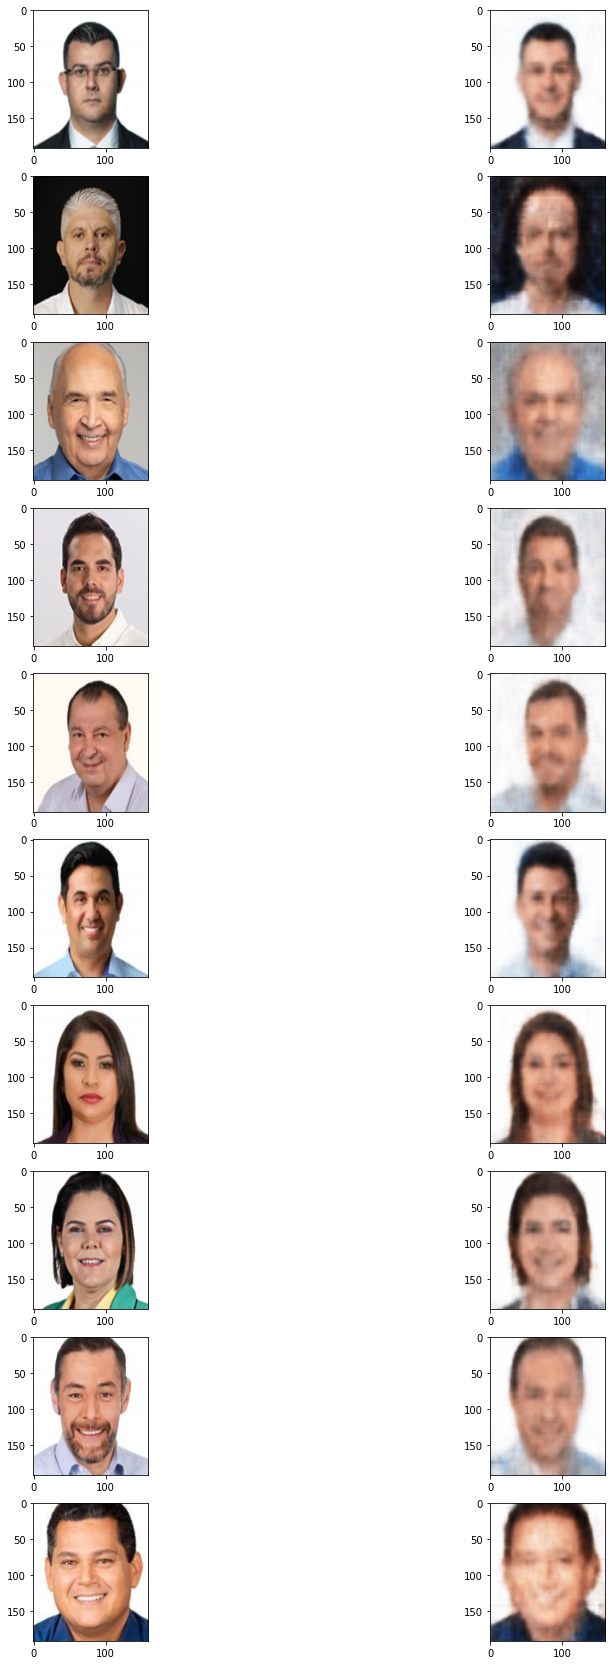

In [17]:
autoencoder_plot_faces_and_their_reconstructions(autoencoder, X_train, 10)

Criar aleatoriamente rosto de candidato eleito

1/1 [==============================] - 0s 172ms/step


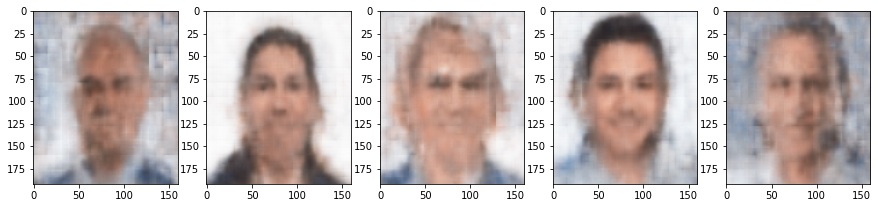

In [18]:
plot_randomly_created_faces(decoder, 5)

Reconstrução de faces a partir de candidatos não presentes no treino

1/1 [==============================] - 0s 124ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


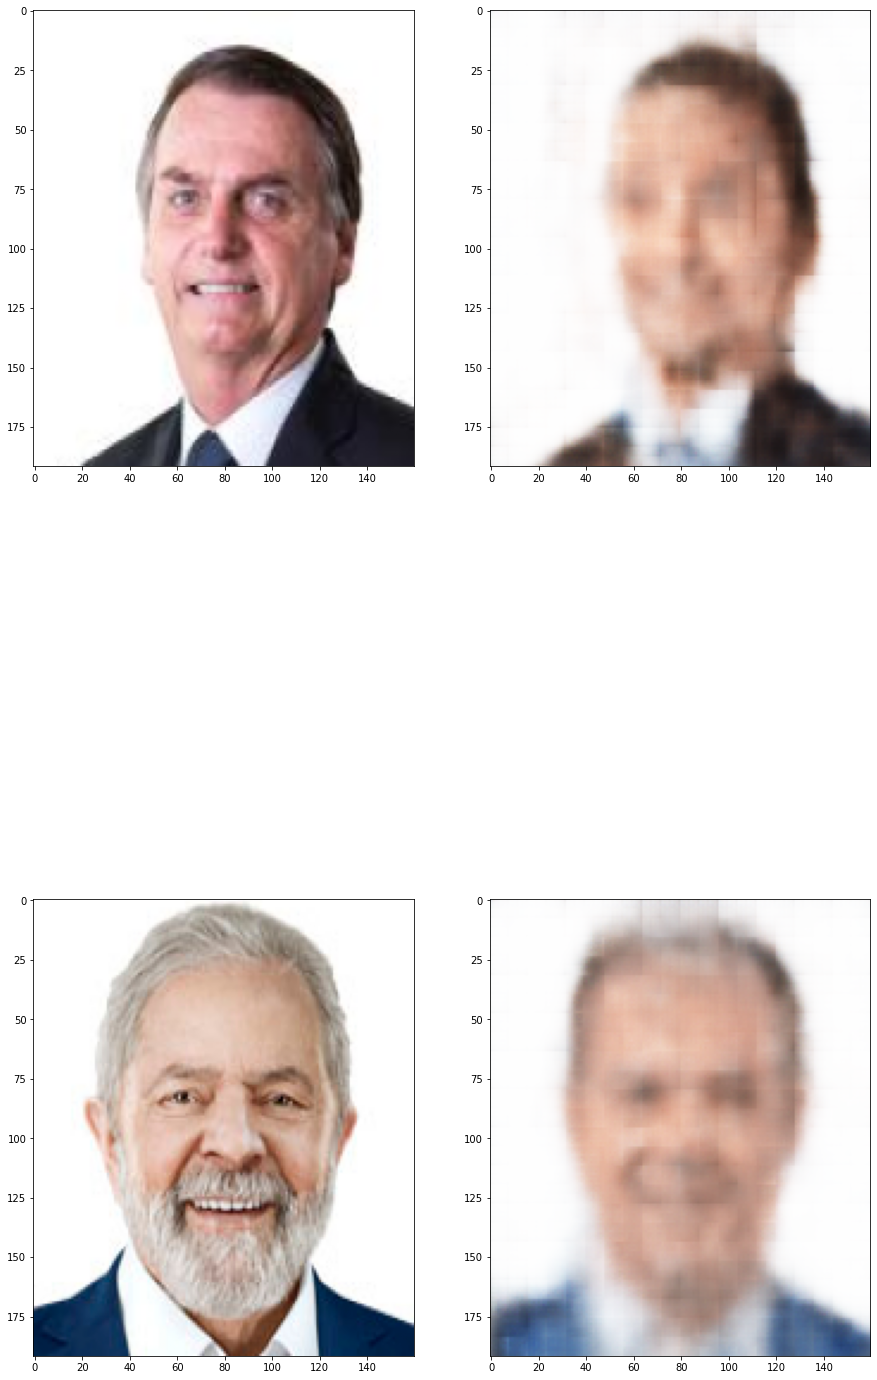

In [19]:
url_foto_lula = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/893498/foto.jpg'
url_foto_bolsonaro = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/908966/foto.jpeg'
foto_lula = open_image_internet(url_foto_lula)
foto_bolsonaro = open_image_internet(url_foto_bolsonaro)
presidenciaveis = get_resized_faces_aux(get_cropped_faces([foto_lula, foto_bolsonaro]), 160, 192)/255
autoencoder_plot_faces_and_their_reconstructions(autoencoder, presidenciaveis, presidenciaveis.shape[0])

Reconstrução de faces a partir de candidatos eleitos

17/17 [==============================] - 0s 18ms/step


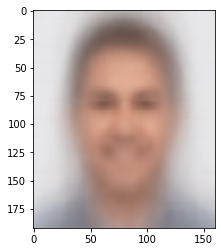

In [20]:
elected_mean_person_autoencoder = autoencoder.predict(X)
elected_mean_person_autoencoder = elected_mean_person_autoencoder.reshape((elected_mean_person_autoencoder.shape[0], np.prod(elected_mean_person_autoencoder.shape[1:]))).mean(axis=0).reshape(elected_mean_person_autoencoder.shape[1:])
plt.imshow(BGR2RGB(elected_mean_person_autoencoder))